In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, recall_score, balanced_accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('proteins_dataframe.csv')
df

,Unnamed: 0,pdb_id,chain_id,sequence,residue,residue_number,res_index,pdb_res_index,Hydrophobicity,Hydrophilicity,NCI,Polarity,Polarizability,SASA,V,is_charged,tm_segment
0,0,1vgo,A,DLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAIT...,D,3,0,5,-0.90,3.0,-0.023820,13.0,0.105,1.587,40.0,1,0
1,1,1vgo,A,DLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAIT...,L,10,1,6,1.06,-1.8,0.051672,4.9,0.186,1.931,93.5,0,0
2,2,1vgo,A,DLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAIT...,L,10,2,7,1.06,-1.8,0.051672,4.9,0.186,1.931,93.5,0,0
3,3,1vgo,A,DLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAIT...,N,12,3,8,-0.78,0.2,0.005392,11.6,0.134,1.655,58.7,0,0
4,4,1vgo,A,DLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAIT...,D,3,4,9,-0.90,3.0,-0.023820,13.0,0.105,1.587,40.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161310,161310,7b0o,A,LYFQGHMDRLITLVVSYSIAFSIFALATMAVVYGKWLYYFEIDFLN...,V,18,211,206,1.08,-1.5,0.057004,5.9,0.140,1.645,71.5,0,0
161311,161311,7b0o,A,LYFQGHMDRLITLVVSYSIAFSIFALATMAVVYGKWLYYFEIDFLN...,K,9,212,207,-1.50,3.0,0.017708,11.3,0.219,2.258,100.0,1,0
161312,161312,7b0o,A,LYFQGHMDRLITLVVSYSIAFSIFALATMAVVYGKWLYYFEIDFLN...,K,9,213,208,-1.50,3.0,0.017708,11.3,0.219,2.258,100.0,1,0
161313,161313,7b0o,A,LYFQGHMDRLITLVVSYSIAFSIFALATMAVVYGKWLYYFEIDFLN...,K,9,214,209,-1.50,3.0,0.017708,11.3,0.219,2.258,100.0,1,0


In [4]:
# remove sequences that are outside of membrane
seq_segm = {}

for ind in df.index:
  if df['sequence'][ind] not in seq_segm:
    seq_segm[df['sequence'][ind]] = 0
  
  seq_segm[df['sequence'][ind]] += df['tm_segment'][ind]

outside_seq = []

for key in seq_segm:
  if seq_segm[key] == 0:
    outside_seq.append(key)

df = df[~df['sequence'].isin(outside_seq)]

In [5]:
# remove sequences with length more the 800 amino acids
df = df[df['sequence'].str.len() < 800]

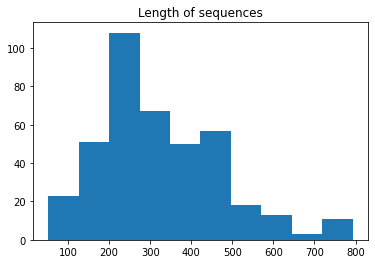

In [20]:
unique_seq = df.sequence.unique()

len_of_sequences = []
for seq in unique_seq:
  len_of_sequences.append(len(seq))

plt.hist(len_of_sequences)
plt.title("Length of sequences")
plt.show()

In [12]:
X = df[['residue_number', 'res_index', 'Hydrophobicity', 'Hydrophilicity', 'NCI', 'Polarity', 'Polarizability', 'SASA', 'V', 'is_charged']]
# X = df[['residue_number', 'Hydrophobicity', 'Hydrophilicity', 'NCI', 'Polarity', 'Polarizability', 'SASA', 'V']]
y = df['tm_segment']

In [7]:
# Data normilizations
scaler = StandardScaler()
scaler.fit(X)
scaled = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled, columns=X.columns)
scaled_df

,residue_number,Hydrophobicity,Hydrophilicity,NCI,Polarity,Polarizability,SASA,V,is_charged
0,-1.268115,-1.235368,2.046999,-1.111856,2.103068,-0.561175,-0.316707,-0.789434,2.268825
1,-0.037428,0.827785,-0.777668,0.109571,-1.166392,0.308144,0.440488,0.677903,-0.440757
2,-0.037428,0.827785,-0.777668,0.109571,-1.166392,0.308144,0.440488,0.677903,-0.440757
3,0.314196,-1.109052,0.399277,-0.639219,1.537976,-0.249938,-0.167029,-0.276552,-0.440757
4,-1.268115,-1.235368,2.046999,-1.111856,2.103068,-0.561175,-0.316707,-0.789434,2.268825
...,...,...,...,...,...,...,...,...,...
138180,1.369070,0.848838,-0.601126,0.195840,-0.762755,-0.185544,-0.189040,0.074512,-0.440757
138181,-0.213241,-1.866945,2.046999,-0.439951,1.416885,0.662310,1.160264,0.856178,2.268825
138182,-0.213241,-1.866945,2.046999,-0.439951,1.416885,0.662310,1.160264,0.856178,2.268825
138183,-0.213241,-1.866945,2.046999,-0.439951,1.416885,0.662310,1.160264,0.856178,2.268825


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # 7 indicates that always get the same split of data each time this example is executed

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic', 'nthread': 4, 'eval_metric': 'auc', 'n_estimators': 1000, 'learning_rate': 0.01}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[18:54:25] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-auc:0.65059	train-auc:0.64357
[1]	eval-auc:0.66564	train-auc:0.65931


/home/dparanou/.local/lib/python3.8/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[2]	eval-auc:0.66534	train-auc:0.65968
[3]	eval-auc:0.66758	train-auc:0.66027
[4]	eval-auc:0.66722	train-auc:0.66041
[5]	eval-auc:0.66898	train-auc:0.66167
[6]	eval-auc:0.66914	train-auc:0.66140
[7]	eval-auc:0.66857	train-auc:0.66101
[8]	eval-auc:0.66910	train-auc:0.66132
[9]	eval-auc:0.66936	train-auc:0.66157


In [15]:
# fit model on training data
model = XGBClassifier(objective="binary:logistic", n_estimators = 200, learning_rate = 0.05, max_depth = 4)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Roc: %.2f%%" % (roc_score* 100.0))

f1 = f1_score(y_test, predictions)
print("F1 score: %.2f%%" % (f1* 100.0))

Accuracy: 63.48%
Roc: 67.99%
F1 score: 62.64%


In [8]:
inner_metric = 'balanced_accuracy_score'
outer_metrics = ['balanced_accuracy_score', 'average_precision', 'f1']


# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=3, shuffle=True)
cv_outer = StratifiedKFold(n_splits=10, shuffle=True)

In [11]:
model = XGBClassifier(objective="binary:logistic")

param_grid = {
  "max_depth": [1, 3, 7, 10],
  "n_estimators": [10, 500, 1000],
  "learning_rate": [0.01, 0.1, 0.2],
}
rounds = 2
for r in range(rounds):
  print("For round",r, ":")
  # define search
  rf_grid = GridSearchCV(model, param_grid, scoring='balanced_accuracy', n_jobs=-1, cv=cv_inner, refit=True)

  # execute the nested cross-validation
  scores = cross_validate(rf_grid, scaled_df, y, scoring='balanced_accuracy', cv=cv_outer, n_jobs=-1)

  #Best
  rf_grid.fit(X, y)
  # params[r] = rf_grid.best_params_
  print("Best parameters: ", rf_grid.best_params_)
  
  # scores[r] = rf_grid.best_score_
  print("Best score: ", rf_grid.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532102797542
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532386523935
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532044164002
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.612953192615667
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532610790335
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532122198383
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.612953238518026
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129532072701179
Best parameters:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}
Best score:  0.6129531919977071
Best paramet

In [16]:
from sklearn.svm import SVC

svm = SVC(gamma='auto')
svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

print('Mathwe cor is : {f} and accuracy is {f}', matthews_corrcoef(y_test.values, ypred), accuracy_score(y_test.values, ypred))

Mathwe cor is : {f} and accuracy is {f} 0.23794918780602722 0.6198574374932156


In [17]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

# num_round = 10
# lgb.cv(param, train_data, num_round, nfold=5)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],verbose=20,eval_metric='auc')

/home/dparanou/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.686705	training's binary_logloss: 0.631069	valid_0's auc: 0.683739	valid_0's binary_logloss: 0.637181
[40]	training's auc: 0.691169	training's binary_logloss: 0.625604	valid_0's auc: 0.68217	valid_0's binary_logloss: 0.635178
[60]	training's auc: 0.694172	training's binary_logloss: 0.623151	valid_0's auc: 0.68071	valid_0's binary_logloss: 0.636153
[80]	training's auc: 0.696375	training's binary_logloss: 0.62142	valid_0's auc: 0.679443	valid_0's binary_logloss: 0.636827
[100]	training's auc: 0.698137	training's binary_logloss: 0.620118	valid_0's auc: 0.678859	valid_0's binary_logloss: 0.637474


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [18]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.6419
Testing accuracy 0.6317


In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error